In [1]:
from IPython.display import display, Image
from pprint import pprint
from itertools import chain

from ginv import *
sympy.init_printing()

Условие на высшие симметрии (сокращенная запись например $u_{xxx} = u_3$)
\begin{equation}
\begin{aligned}
\mathbf{u_{t}}& + 6 u_1 u + u_3 = 0 \\
\mathbf{u_{\varepsilon }}& - F(t, x, u, u_1, u_2, \ldots, u_5) = 0 \\
\end{aligned}
\end{equation}
Для второго уравнения системы введем полные производные от $F$.
\begin{equation}
\begin{aligned}
\frac{dF}{dt} &= F_t  - F_u (6 u_1 u + u_3) - \sum F_{u_{i}} (6 u_1 u + u_3)_i\\
\frac{dF}{dx} &= F_x  + F_u  u_1 + \sum F_{u_{i}} u_{i+1}
\end{aligned}
\end{equation}

Условие интегрируемости (совместности) данной системы можно записать через $S$-полином (лексикографическое упорядочение $t \succ x $)
\begin{equation}
\big(\mathbf{u_{t}}  + 6 u_1 u + u_3)_\varepsilon 
- \mathbf{u_{\varepsilon t}} + \frac{d}{dt}F = 0
\end{equation}

В последнем уравнении в силу правила дифференцирования Лейбница производная по $\varepsilon $
входит в условие интрегриемости линейно. 
\begin{equation}
6𝑢 𝑢_{\varepsilon 1}+  6𝑢_1 𝑢_{\varepsilon }+ 𝑢_{\varepsilon 3}
\frac{d}{dt}F = 0
\end{equation}
При этом мы можем заменить $u_{\varepsilon }$ на $F$ используя полные производные от $F$.
\begin{equation}
6𝑢 \frac{d}{dx}F+  6𝑢_1 F + \frac{d^3}{dx^3}F + \frac{d}{dt}F = 0
\end{equation}

Поскольку само $F$ не зависит от производных выше пятого порядка можно получить 
систему линейных уравнений на $F$.

In [2]:
eps, t, x = sympy.symbols('ε, t, x', real=True)
U = sympy.Function('u')(eps, t, x)

u, ut, u1, u2, u3, u4, u5 = sympy.symbols('u, u_t, u_1, u_2, u_3, u_4, u_5', real=True)
F = sympy.Function('f')(t, x, u, u1, u2, u3, u4, u5)

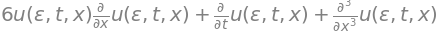

In [3]:
eq1 = U.diff(t) + 6*U*U.diff(x) + U.diff(x, 3)
eq1

In [4]:
func_poly = set([sympy.Add, sympy.Mul, sympy.Pow])
def compact(f):
    def cmpct(a):
        if not a.args:
            return a
        else:
            if a.func in func_poly:
                return a.func(*tuple(cmpct(s) for s in a.args))
            elif a.func != sympy.Derivative:
                return sympy.Symbol(f"{a.func}")
            else:
                m = []
                for xi, k in a.args[1:]:
                    m.append(f"{xi}"*k)
                return sympy.Symbol(f"{a.args[0].func}_{{{''.join(m)}}}", real=True)
    return cmpct(f)

In [5]:
compact(eq1)

In [6]:
compact(eq1.diff(eps))

In [7]:
def Dt(a):
    return a.diff(t) -\
        sum(a.diff(f)*(6*U*U.diff(x) + U.diff(x, 3)).diff(x, k)\
            for k, f in enumerate([u, u1, u2, u3, u4, u5]))
def Dx(a):
    return a.diff(x) +\
        sum(a.diff(f)*U.diff(x, k+1)\
            for k, f in enumerate([u, u1, u2, u3, u4, u5]))

In [8]:
compact(Dt(F)).expand()

In [9]:
compact(Dx(F))

In [10]:
toD = {
    t: Dt,\
    x: Dx,\
}
def totalD(a):
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(totalD(s) for s in a.args))
        elif (eps, 1) not in a.args:
            return a
        else:
            assert a.args[0] == U
            r = F
            for v, l in a.args[1:]:
                if v != eps:
                    for i in range(l):
                        r = toD[v](r)
            return r

In [11]:
eq2 = totalD(eq1.diff(eps)).expand()
compact(eq2)

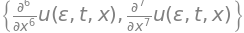

In [12]:
toU = dict((U.diff(x, k), f) for k, f in enumerate([u, u1, u2, u3, u4, u5]))
DF = set()
def lstD(a):
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(lstD(s) for s in a.args))
        elif a.args[0] != U:
            return a
        elif a in toU:
            return toU[a]
        else:
            DF.add(a)
            return a
eq4 = lstD(eq2).expand()
DF

In [13]:
[compact(df) for df in DF]

In [14]:
def to_eqs(a, var):
    for x in var:
        r = []
        for b in a:
            if b:
                r.append([b.coeff(x, i) for i in range(b.as_poly(x).degree()+1) if b.coeff(x, i)])
        a = chain(*r)
    return list(a)

eqs = to_eqs([eq4], DF)
eqs = [eq.subs({U: u}) for eq in eqs]
for eq in eqs:
    print(sympy.latex(compact(eq)) + r" = 0, \\")
    print(len(eq.args))
[compact(eq) for eq in eqs]

6 f u_{1} + f_{t} + f_{u_1u_1u_1} u_{2}^{3} + 3 f_{u_1u_1u_2} u_{2}^{2} u_{3} + 3 f_{u_1u_1u_3} u_{2}^{2} u_{4} + 3 f_{u_1u_1u_4} u_{2}^{2} u_{5} + 3 f_{u_1u_1x} u_{2}^{2} + 3 f_{u_1u_1} u_{2} u_{3} + 3 f_{u_1u_2u_2} u_{2} u_{3}^{2} + 6 f_{u_1u_2u_3} u_{2} u_{3} u_{4} + 6 f_{u_1u_2u_4} u_{2} u_{3} u_{5} + 6 f_{u_1u_2x} u_{2} u_{3} + 3 f_{u_1u_2} u_{2} u_{4} + 3 f_{u_1u_2} u_{3}^{2} + 3 f_{u_1u_3u_3} u_{2} u_{4}^{2} + 6 f_{u_1u_3u_4} u_{2} u_{4} u_{5} + 6 f_{u_1u_3x} u_{2} u_{4} + 3 f_{u_1u_3} u_{2} u_{5} + 3 f_{u_1u_3} u_{3} u_{4} + 3 f_{u_1u_4u_4} u_{2} u_{5}^{2} + 6 f_{u_1u_4x} u_{2} u_{5} + 3 f_{u_1u_4} u_{3} u_{5} + 3 f_{u_1xx} u_{2} + 3 f_{u_1x} u_{3} - 6 f_{u_1} u_{1}^{2} + f_{u_2u_2u_2} u_{3}^{3} + 3 f_{u_2u_2u_3} u_{3}^{2} u_{4} + 3 f_{u_2u_2u_4} u_{3}^{2} u_{5} + 3 f_{u_2u_2x} u_{3}^{2} + 3 f_{u_2u_2} u_{3} u_{4} + 3 f_{u_2u_3u_3} u_{3} u_{4}^{2} + 6 f_{u_2u_3u_4} u_{3} u_{4} u_{5} + 6 f_{u_2u_3x} u_{3} u_{4} + 3 f_{u_2u_3} u_{3} u_{5} + 3 f_{u_2u_3} u_{4}^{2} + 3 f_{u_2u_4u_4

In [15]:
Monom.cmp = Monom.TOPdeglex

In [16]:
var = 't, x, u, u_1, u_2, u_3, u_4, u_5'.split(', ')
fun = ['f']
var, fun = PolyDiff.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
t, x, u, u1, u2, u3, u4, u5 = var
F = fun[0]

In [17]:
diff2poly(eqs[1])

[[[0;0 1 0 0 0 0 0 1], 3],
 [[0;0 0 1 0 0 0 0 1], 3*u_1],
 [[0;0 0 0 1 0 0 0 1], 3*u_2],
 [[0;0 0 0 0 1 0 0 1], 3*u_3],
 [[0;0 0 0 0 0 1 0 1], 3*u_4],
 [[0;0 0 0 0 0 0 1 1], 3*u_5]]

In [18]:
print(diff2poly(eqs[1]))

df(f, x, u_5)*3 + df(f, u, u_5)*3*u_1 + df(f, u_1, u_5)*3*u_2 + df(f, u_2, u_5)*3*u_3 + df(f, u_3, u_5)*3*u_4 + df(f, u_4, u_5)*3*u_5


In [19]:
LRT = Janet()
res = ginvBlockLow([diff2poly(eq) for eq in eqs], \
LRT, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT.count()}")
print(f"reduction: {LRT.reduction()}")
print(f"       HP: {LRT.HP()}")

prolong 0, Q 2
df(f, u_5, 2)
prolong 0, Q 2
df(f, x, u_5)
prolong 2, Q 3
df(f, u_4, u_5)
prolong 2, Q 3
df(f, u_3, u_5)
prolong 2, Q 3
df(f, u_2, u_5)
prolong 2, Q 3
df(f, u_1, u_5)
prolong 2, Q 3
df(f, u, u_5)
prolong 2, Q 3
df(f, x, u_4)
prolong 2, Q 3
df(f, u_4, 2)
prolong 2, Q 3
df(f, u_3, u_4, 2)
prolong 2, Q 3
df(f, u_3, u_4, u_5)
prolong 3, Q 3
df(f, u_2, u_4, 2)
prolong 2, Q 3
df(f, u_2, u_4, u_5)
prolong 3, Q 3
df(f, u_1, u_4, 2)
prolong 2, Q 3
df(f, u_1, u_4, u_5)
prolong 3, Q 3
df(f, u, u_4, 2)
prolong 2, Q 3
df(f, u, u_4, u_5)
prolong 3, Q 3
df(f, u_3, u_4)
prolong 2, Q 3
df(f, u_2, u_3, u_4)
prolong 2, Q 3
df(f, u_2, u_3, u_5)
prolong 3, Q 3
df(f, u_1, u_3, u_4)
prolong 2, Q 3
df(f, u_1, u_3, u_5)
prolong 3, Q 3
df(f, u, u_3, u_4)
prolong 2, Q 3
df(f, u, u_3, u_5)
prolong 3, Q 3
df(f, u_2, u_4)
prolong 2, Q 3
df(f, u_1, u_2, u_4)
prolong 2, Q 3
df(f, u_1, u_2, u_5)
prolong 3, Q 3
df(f, u, u_2, u_4)
prolong 2, Q 3
df(f, u, u_2, u_5)
prolong 3, Q 3
df(f, u_1, u_4)
prolong 2,

In [20]:
for w in LRT.GB():
    print(w.lm.df_latex(), w.poly)

{f}_{{u_5} {u_5}} df(f, u_5, 2)
{f}_{{u_4}} df(f, u_4)
{f}_{{u_3} {u_5}} df(f, u_3, u_5)
{f}_{{u_3} {u_3}} df(f, u_3, 2)
{f}_{{u_2}} df(f, u_2) + df(f, u_5)*-20*u_1
{f}_{{u_1} {u_5}} df(f, u_1, u_5)
{f}_{{u_1} {u_3}} df(f, u_1, u_3)
{f}_{{u_1} {u_1}} df(f, u_1, 2)
{f}_{{u} {u_5}} df(f, u, u_5)
{f}_{{u} {u_3}} df(f, u, u_3) + df(f, u_5)*-10
{f}_{{u} {u_1}} df(f, u, u_1) + df(f, u_3)*-6
{f}_{{u} {u}} df(f, u, 2) + df(f, u_5)*-60*u_1
{f}_{{x}} df(f, x)*-2 + df(f, u)*u_1 + df(f, u_3)*-6*u_1**2 + df(f, u_5)*-10*u_1*u_3
{f}_{{t}} df(f, t)*2 + df(f, u)*6*u*u_1 + 3*u_3 + df(f, u_1)*-12*u_1**2 + df(f, u_3)*-36*u*u_1**2 - 30*u_1*u_3 + df(f, u_5)*-60*u*u_1*u_3 - 12*u_1*u_5 - 30*u_3**2 + df(f)*12*u_1


In [21]:
A, B, C, D = [sympy.Function(f)(t, x, u, u2) for f in "A, B, C, D".split(', ')]
F = [A*u5 + B*u3 + C*u1 + D]
eqs5 = []
for w in LRT.GB():
    eqs5.append(sum(F[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c\
                    if m.position() >=0 else c for m, c in w.poly).expand())
[compact(eq) for eq in eqs5]

In [22]:
eqs5 = to_eqs(eqs5, [u1, u3, u5])
[compact(eq) for eq in eqs5]

In [23]:
var = 't, x, u, u_2'.split(', ')
fun = "A, B, C, D".split(', ')
var, fun = PolyDiff.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
t, x, u, u2 = var
A, B, C, D = fun

LRT1 = Forest(Janet)
res = ginvBlockLow([diff2poly(eq) for eq in eqs5], \
LRT1, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT1.count()}")
print(f"reduction: {LRT1.reduction()}")
print(f"       HP: {LRT1.HP()}")

prolong 0, Q 1
df(D, u_2)
prolong 0, Q 1
df(C, u_2)
prolong 0, Q 1
df(B, u_2)
prolong 0, Q 1
df(A, u_2)
prolong 0, Q 1
df(C, u)
prolong 1, Q 1
df(B, u)
prolong 1, Q 1
df(A, u)
prolong 1, Q 1
df(D, x)
prolong 1, Q 1
df(C, x)
prolong 1, Q 1
df(B, x)
prolong 1, Q 1
df(A, x)
prolong 1, Q 1
df(D, t)
prolong 1, Q 1
df(C, t)
prolong 1, Q 1
df(B, t)
prolong 1, Q 1
df(A, t)
prolong 1, Q 2
df(D, u, 2)
prolong 1, Q 2
df(D, u, u_2)
prolong 2, Q 2
prolong 2, Q 0
prolong 0, Q 0
    crit1: 0
    crit2: 0
     time: 0.06 sec
    count: 17
reduction: 97
       HP: 5


In [24]:
for w in LRT1:
    print('$', " + ".join(f"{m.df_latex()} {c}" for m, c in w.poly), '$,')

$ {A}_{{u_2}} 1 $,
$ {A}_{{u}} 1 $,
$ {A}_{{x}} 1 $,
$ {A}_{{t}} 1 $,
$ {B}_{{u_2}} 1 $,
$ {B}_{{u}} 1 + {A} -10 $,
$ {B}_{{x}} 1 $,
$ {B}_{{t}} 2 + {D}_{{u}} 3 $,
$ {C}_{{u_2}} 1 + {A} -20 $,
$ {C}_{{u}} 1 + {B} -6 $,
$ {C}_{{x}} -2 + {D}_{{u}} 1 $,
$ {C}_{{t}} 1 + {D}_{{u}} 3*u + {D} 6 $,
$ {D}_{{u_2}} 1 $,
$ {D}_{{u} {u_2}} 1 $,
$ {D}_{{u} {u}} 1 $,
$ {D}_{{x}} 1 $,
$ {D}_{{t}} 1 $,


In [25]:
A0, B0, D0, D1, C0 = sympy.symbols("A, B, D0, D1, C")
B = 10*A0*u - 3*t*D1/2 + B0
C = 20*A0*u2 + x*D1/2  + 30*A0*u**2 - 18*t*D1/2*u + 6*B0*u - 6*t*D0 + C0
D = D1*u + D0
F = [A0, B, C, D]
eqs6 = []
for w in LRT1.GB():
    eqs6.append(sum(F[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c\
                    if m.position() >=0 else c for m, c in w.poly).expand())
[compact(eq) for eq in eqs6]

In [26]:
F = (A0*u5 + B*u3 + C*u1 + D).expand()
F

In [27]:
for eq in eqs:
    print(eq.subs(sympy.Function('f')(t, x, u, u1, u2, u3, u4, u5), F)\
          .doit().expand(), end=' ')

0 0 0 0 0 0 

In [28]:
symm = [F.coeff(i) for i in (A0, B0, D0, D1, C0)]
symm

In [29]:
for s in symm:
    print(sympy.latex(s))

30 u^{2} u_{1} + 10 u u_{3} + 20 u_{1} u_{2} + u_{5}
6 u u_{1} + u_{3}
- 6 t u_{1} + 1
- 9 t u u_{1} - \frac{3 t u_{3}}{2} + u + \frac{u_{1} x}{2}
u_{1}


In [30]:
sympy.solve([compact(eq1), compact(eq1.diff(x, 2))], [compact(U.diff(x, 3)), compact(U.diff(x, 5))])

In [31]:
[s.subs({u3: -(ut + 6*u*u1)}).expand() for s in symm]

In [32]:
for s in symm:
    print(sympy.latex(s.subs({u3: -(ut + 6*u*u1)}).expand()))

- 30 u^{2} u_{1} - 10 u u_{t} + 20 u_{1} u_{2} + u_{5}
- u_{t}
- 6 t u_{1} + 1
\frac{3 t u_{t}}{2} + u + \frac{u_{1} x}{2}
u_{1}
